In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print('TF version: ', tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Memory Growth = True')

TF version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory Growth = True


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

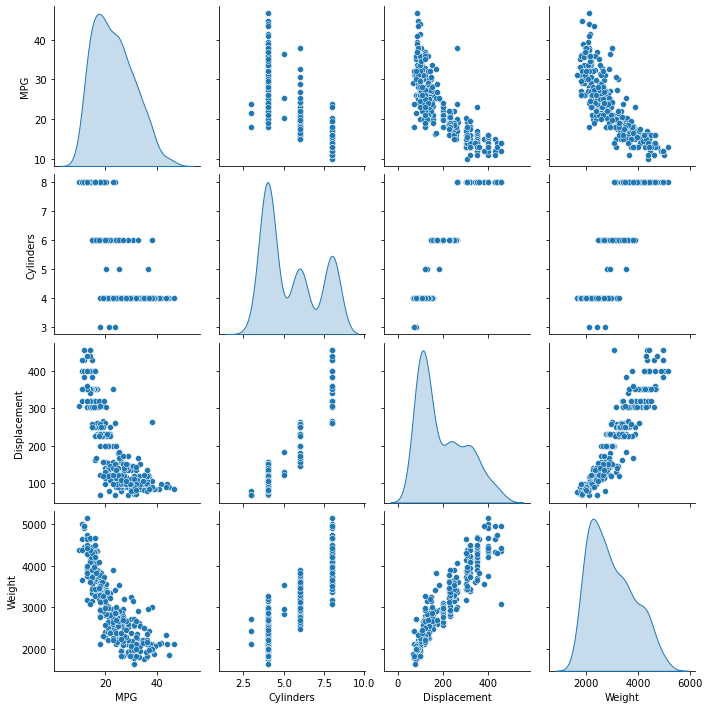

In [6]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [8]:
x_train = train_dataset.copy()
x_test = test_dataset.copy()

y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')

x_train = np.array(x_train).astype('float32')
x_test = np.array(x_test).astype('float32')

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

In [9]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x_train)
print(normalizer.mean.numpy())

[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
 7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]


In [53]:
model = keras.Sequential([
    normalizer,
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1),
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_23 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [54]:
model.compile(
    loss=keras.losses.MAE,
    optimizer=keras.optimizers.Adam(lr=0.1),
)

In [55]:
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=1000, verbose=0, validation_split=0.2)

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,2.006130,2.377959,995
996,2.049021,2.897399,996
997,2.212194,2.571379,997
998,2.111418,2.497652,998
999,2.145514,2.444300,999


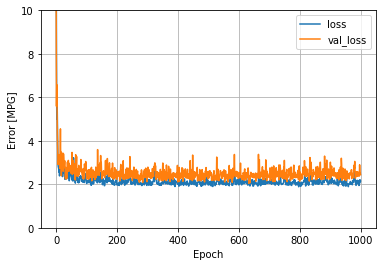

In [57]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [58]:
result = model.evaluate(x_test, y_test, verbose=0)

In [59]:
print(result)
print(model.metrics_names)

2.1679303646087646
['loss']
